Solving(?) Blackjack with Monte Carlo ES


In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from mpl_toolkits.mplot3d import Axes3D
from collections import deque

%matplotlib widget

In [ ]:
class BlackjackEnv(gym.Env):
    CARDS = [*range(1, 10)] + [10] * 4

    def __init__(self):
        super().__init__()

        self.observation_space = spaces.MultiDiscrete([10, 10, 2], start=[1, 12, 0])
        self.action_space = spaces.Discrete(2)

    @classmethod
    def draw(cls):
        return np.random.choice(cls.CARDS)

    def reset(self):
        self.state = self.observation_space.sample()
        return tuple(self.state), {}

    # action: 0 is stand, 1 is hit
    def step(self, action):
        dealer, p_sum, ace = self.state
        reward = None
        terminated = False

        if action == 0:
            d_sum = 11 if dealer == 1 else dealer
            d_ace = 1 if dealer == 1 else 0
            while d_sum < 12:
                card = BlackjackEnv.draw()
                d_ace |= card == 1
                d_sum += 11 if (card == 1 and d_ace == 0) else card
            while d_sum <= 16 or (d_sum == 17 and d_ace == 1):
                d_sum += BlackjackEnv.draw()
                if d_sum > 21:
                    if d_ace == 1:
                        d_sum -= 10
                        d_ace = 0
                    else:
                        reward = 1
                        break
            if reward is None:
                reward = 1 if p_sum > d_sum else -1 if p_sum < d_sum else 0
            self.state = None
            terminated = True
        else:
            p_sum += BlackjackEnv.draw()
            if p_sum > 21:
                if ace == 1:
                    p_sum -= 10
                    ace = 0
                    reward = 0
                else:
                    reward = -1
                    terminated = True
            else:
                reward = 0
            self.state = (dealer, p_sum, ace)

        return self.state, reward, terminated, False, {}

In [94]:
class BlackjackAgent:
    def __init__(self, env: gym.Env, discount_factor: float):
        self.env = env
        self.gamma = discount_factor

        # self.pi = np.random.randint(0, 2, (11, 22, 2))
        self.pi = np.empty((11, 22, 2), dtype=int)
        for dealer in range(1, 11):
            for p_sum in range(12, 22):
                for ace in range(2):
                    self.pi[dealer, p_sum, ace] = 0 if p_sum >= 20 else 1

        self.q = np.random.randn(11, 22, 2, 2)
        self.vis = np.zeros((11, 22, 2))

    def train(self):
        s, _ = self.env.reset()
        a = np.random.randint(0, 2)
        states = [s]
        actions = [a]
        rewards = []
        terminated = False
        while True:
            s, r, terminated, _, _ = self.env.step(a)
            rewards.append(r)
            if terminated:
                break
            a = self.pi[s]
            states.append(s)
            actions.append(a)

        # print(f"{states=}, {actions=}, {rewards=}")

        g = 0
        while len(rewards) > 0:
            s, a, r = states.pop(), actions.pop(), rewards.pop()
            g = self.gamma * g + r
            self.vis[s] += 1
            alpha = 1 / self.vis[s]
            # alpha = 0.005
            self.q[s + (a,)] += alpha * (g - self.q[s + (a,)])
            self.pi[s] = np.argmax(self.q[s])

    def monte_carlo_es(self):
        for ep in range(2000000):
            self.train()

In [95]:
env = BlackjackEnv()
# env.reset()
agent = BlackjackAgent(env, 1)
# agent.pi.shape
agent.monte_carlo_es()

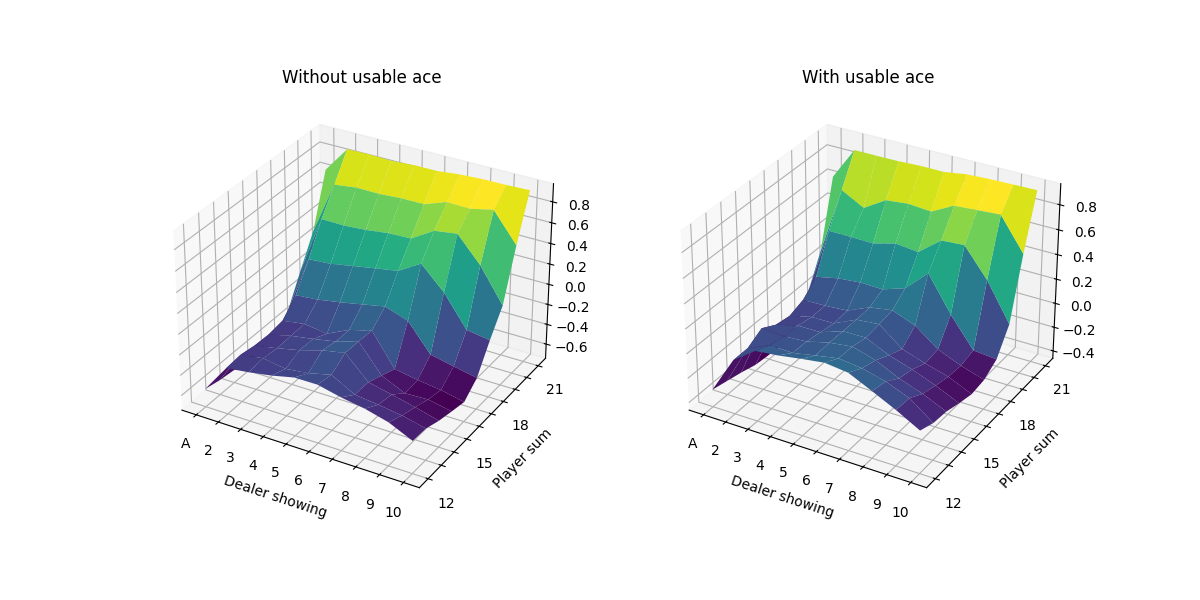

In [96]:
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
no_ace, with_ace = axs
no_ace: Axes3D
with_ace: Axes3D

yticks = range(12, 22)
ylabels = [str(tick) if tick in (12, 15, 18, 21) else "" for tick in yticks]

x = np.arange(1, 11)
y = np.arange(12, 22)
x, y = np.meshgrid(x, y, indexing="ij")

v_no_ace = np.max(agent.q[1:11, 12:22, 0, :], axis=2)
no_ace.plot_surface(x, y, v_no_ace, cmap="viridis")
no_ace.set_xlabel("Dealer showing")
no_ace.set_xticks(range(1, 11), labels=(["A"] + [*range(2, 11)]))
no_ace.set_ylabel("Player sum")
no_ace.set_yticks(yticks, labels=ylabels)
no_ace.set_title("Without usable ace")

v_with_ace = np.max(agent.q[1:11, 12:22, 1, :], axis=2)
with_ace.plot_surface(x, y, v_with_ace, cmap="viridis")
with_ace.set_xlabel("Dealer showing")
with_ace.set_xticks(range(1, 11), labels=(["A"] + [*range(2, 11)]))
with_ace.set_ylabel("Player sum")
with_ace.set_yticks(yticks, labels=ylabels)
with_ace.set_title("With usable ace")

plt.show()

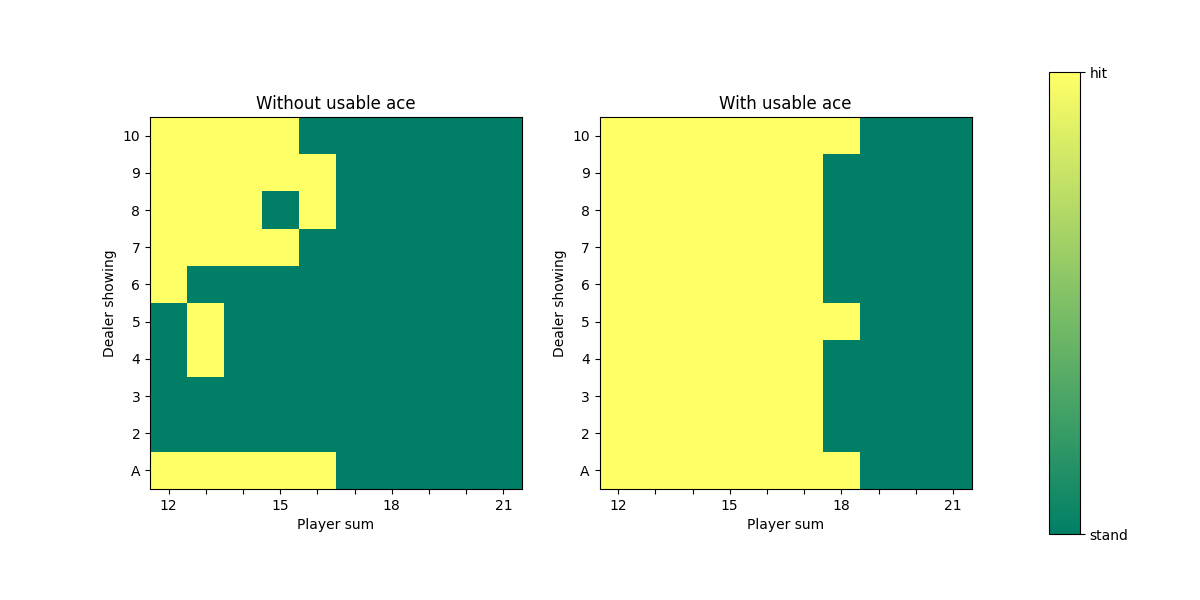

In [97]:
fig, axs = plt.subplots(
    1, 3, figsize=(12, 6), gridspec_kw={"width_ratios": [12, 12, 1]}
)
fig.subplots_adjust(wspace=0.3)
no_ace, with_ace, cbar_ax = axs
no_ace: Axes
with_ace: Axes
cbar_ax: Axes

xticks = range(12, 22)
xlabels = [str(tick) if tick in (12, 15, 18, 21) else "" for tick in yticks]

no_ace_im = no_ace.imshow(
    agent.pi[1:11, 12:22, 0],
    extent=[12 - 0.5, 21 + 0.5, 1 - 0.5, 10 + 0.5],
    origin="lower",
    cmap="summer",
)
no_ace.set_xlabel("Player sum")
no_ace.set_xticks(xticks, labels=xlabels)
no_ace.set_ylabel("Dealer showing")
no_ace.set_yticks(range(1, 11), labels=(["A"] + [*range(2, 11)]))
no_ace.set_title("Without usable ace")

with_ace_im = with_ace.imshow(
    agent.pi[1:11, 12:22, 1],
    extent=[12 - 0.5, 21 + 0.5, 1 - 0.5, 10 + 0.5],
    origin="lower",
    cmap="summer",
)
with_ace.set_xlabel("Player sum")
with_ace.set_xticks(xticks, labels=xlabels)
with_ace.set_ylabel("Dealer showing")
with_ace.set_yticks(range(1, 11), labels=(["A"] + [*range(2, 11)]))
with_ace.set_title("With usable ace")

cbar = plt.colorbar(with_ace_im, cax=cbar_ax, ticks=[0, 1])
# cbar_ax.axis("off")
cbar.ax.set_yticklabels(["stand", "hit"])
plt.show()

In [69]:
q0 = agent.q[1:11, 12:22, 0, :]
v = np.max(q0, axis=2)
# m = np.max(agent.q, axis=3)
# m[1, 12, 1]
np.average(agent.vis[1:11, 12:22, 0]), np.average(agent.vis[1:11, 12:22, 1])

(np.float64(821.49), np.float64(599.6))

In [200]:
x = np.zeros((2, 2))
x[np.int64(1), np.int64(0)]
x = deque([1])
x.appendleft(0)
x.append(2)
(2, 3) + (1,)
x = np.random.randint(0, 3, (2, 2, 2, 2))
np.argmax(x[1, 1, 1])

np.int64(1)

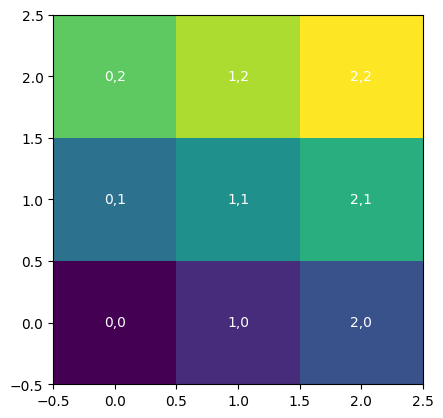

In [31]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

fig, ax = plt.subplots()
ax.imshow(X, origin="lower")

for x in range(3):
    for y in range(3):
        text = ax.text(x, y, f"X[{x}][{y}]", ha="center", va="center", color="w")

plt.show()

In [17]:
A = np.array([[1, 2, 3], [4, 5, 6]])
A[0, 1]

np.int64(2)